In [1]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
directory_path = r'C:/Users/borge/Desktop/HPLC DATA ARISTOLOCHIA_ANDREW'
os.chdir(directory_path)
%pwd

'C:\\Users\\borge\\Desktop\\HPLC DATA ARISTOLOCHIA_ANDREW'

### Converte os arquivos exportados para arquivos de tabela simples

In [3]:
def extract_data(file_path):
    data = []
    start_extraction = False

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("R.Time (min)"):
                start_extraction = True
                continue
            if start_extraction:
                columns = line.strip().split()
                if len(columns) == 2:
                    # Replace commas with dots in each column
                    columns = [col.replace(',', '.') for col in columns]
                    data.append(columns)

    return data

def main():
    input_folder = directory_path
    output_folder = directory_path

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file_name in os.listdir(input_folder):
        if file_name.endswith(".txt"):
            file_path = os.path.join(input_folder, file_name)
            data = extract_data(file_path)

            # Save the data into a new file
            output_file_path = os.path.join(output_folder, f"{os.path.splitext(file_name)[0]}_table.csv")
            with open(output_file_path, 'w') as output_file:
                for row in data:
                    output_file.write('\t'.join(row) + '\n')

if __name__ == "__main__":
    main()


#### Extrai os dados importados para formar a tabela para análise

In [4]:
# Get a list of all files matching the pattern *_table.txt
file_list = glob.glob('*_table.csv')

# Initialize an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through each file and read its data into a DataFrame
for file in file_list:
    # Extracting the file name (excluding the extension) to use as a column header
    column_name = file.split('_table.csv')[0]
    
    # Assuming the files are tab-delimited, you can adjust the delimiter accordingly
    df = pd.read_csv(file, delimiter='\t')
    
    # Add the data to the combined DataFrame with the file name as the column header
    combined_df[column_name] = df.iloc[:, 1]  # Assuming you want the second column, adjust as needed

# Assuming the files are tab-delimited, you can adjust the delimiter accordingly
df1 = pd.read_csv(file, delimiter='\t', header=None)
axis = df1.iloc[:, 0]
    
# Set the row number after which you want to remove rows
row_to_remove_after = 4200  # Change this to the desired row number
# Remove rows after the specified row number
combined_df = combined_df.iloc[:row_to_remove_after]
axis = axis.iloc[:row_to_remove_after]

# Concatenate 'axis' DataFrame with 'combined_df'
combined_df2 = pd.concat([axis, combined_df], axis=1)
combined_df2.rename(columns={0:"RT(min)"},inplace=True)

# Save the combined DataFrame to a CSV file
combined_df2.to_csv('combined_data.csv', sep=";",index=False)

#### Análise dos dados

In [5]:
combined_df2.shape

(4200, 48)

<Figure size 1000x600 with 0 Axes>

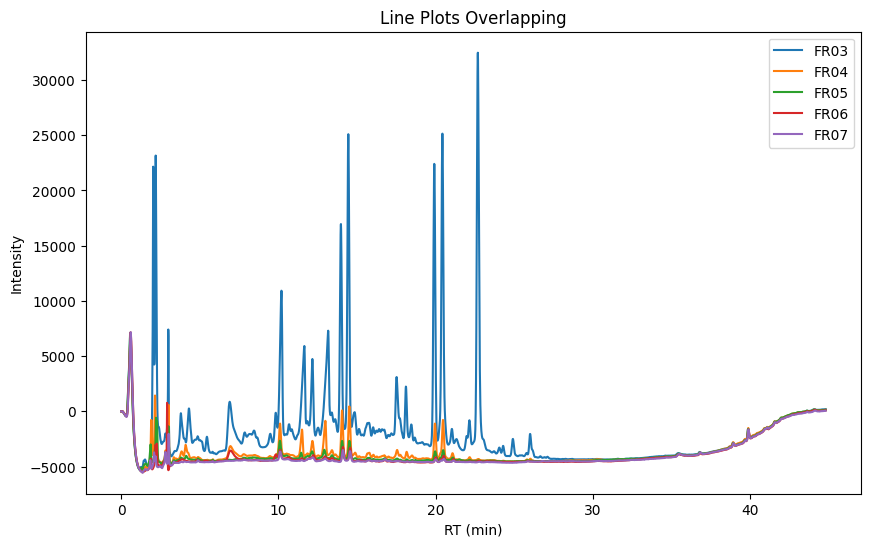

In [6]:
# Plotting
plt.figure(figsize=(10, 6))

# Define the range of columns you want to plot (columns 4 to 8 in this case)
start_column = 8
end_column = 12

# Enable interactive mode in Jupyter Notebook
%matplotlib inline

# Plotting
plt.figure(figsize=(10, 6))

# Loop through the specified range of columns and plot a line
for column in combined_df2.columns[start_column:end_column + 1]:
    plt.plot(combined_df2['RT(min)'], combined_df2[column], label=column)

# Add labels and title
plt.xlabel('RT (min)')
plt.ylabel('Intensity')
plt.title('Line Plots Overlapping')

# Add a legend
plt.legend()

# Set the axis limits to enable zooming
#plt.axis([xmin, xmax, ymin, ymax])

# Show the plot
plt.show()


### PCA

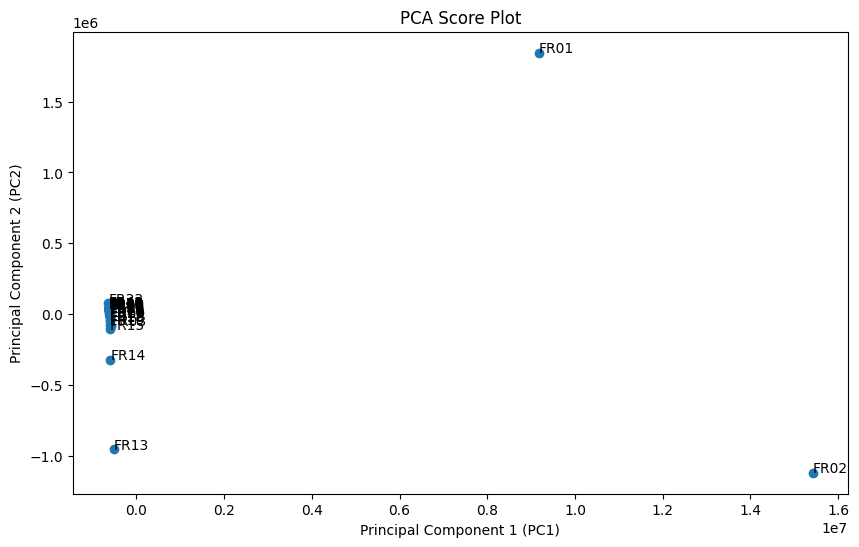

In [27]:
from sklearn.decomposition import PCA

# Extract the feature columns (excluding the 'RT(min)' column)
X = combined_df
X = X.T
X = X.iloc[5:]

# Perform PCA
pca = PCA(n_components=2)
scores = pca.fit_transform(X)

# Create a DataFrame for the scores
scores_df = pd.DataFrame(data=scores, columns=['PC1', 'PC2'])

# Plot the score plot
plt.figure(figsize=(10, 6))
plt.scatter(scores_df['PC1'], scores_df['PC2'])

# Add labels and title
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.title('PCA Score Plot')

# Identify points on the plot using the index of X
for i, sample_name in enumerate(X.index):
    plt.annotate(sample_name, (scores_df['PC1'][i], scores_df['PC2'][i]))

# Show the plot
plt.show()